In [1]:
!nvidia-smi -L

GPU 0: Tesla K80 (UUID: GPU-404b5fba-ff07-5f5c-2ff8-562d99acfb15)


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import tensorflow as tf

**import Libraries**

In [6]:
import cv2
import os
import glob
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from matplotlib.patches import Circle
from sklearn.model_selection import train_test_split
from google.colab import files
from PIL import Image
import random
import tensorflow.keras.backend as K
from tensorflow.keras.layers import Input
from tensorflow.keras.models import load_model
from tensorflow.keras.layers import Conv2D,MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model
from tensorflow.keras.utils import plot_model
import seaborn as sns
from sklearn.metrics import confusion_matrix

import warnings
warnings.filterwarnings('ignore')

import logging
logger = tf.get_logger()
logger.setLevel(logging.ERROR)

**Import Dataset**

In [7]:
multi_faces_dir = tf.io.gfile.glob('/content/drive/MyDrive/Biometric-Project/multi-faces/*')
print(f'Total number of samples in multi faces dataset = {len(multi_faces_dir)}')

Total number of samples in multi faces dataset = 10


**Plot some random Images from multi faces dataset**

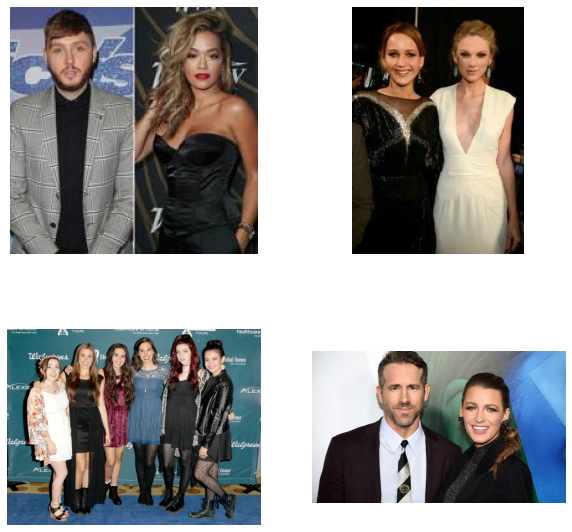

In [ ]:
plt.figure(1, figsize=(10, 10))
plt.axis('off')
n = 0
for i in range(4):
  n += 1
  random_img = random.choice(multi_faces_dir)
  imgs = cv2.imread(random_img)
  #images read by OpenCV are in the format bgr, so we need to swap the order
  b,g,r = cv2.split(imgs)
  imgs = cv2.merge([r,g,b]) 
  plt.subplot(2, 2, n)
  plt.axis('off')
  plt.imshow(imgs)

plt.show()

**Face Detection using OpenCV CascadeClassifier**

In [8]:
face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')

In [9]:
def extract_faces(image, faces):
  ext_faces = []
  img = cv2.imread(image)
  # plot each face as a subplot
  for i in range(0,len(faces)): 
    x1, y1, width, height = faces[i]
    x2, y2 = x1 + width, y1 + height
    ext_faces.append(img[y1:y2, x1:x2])
  return ext_faces

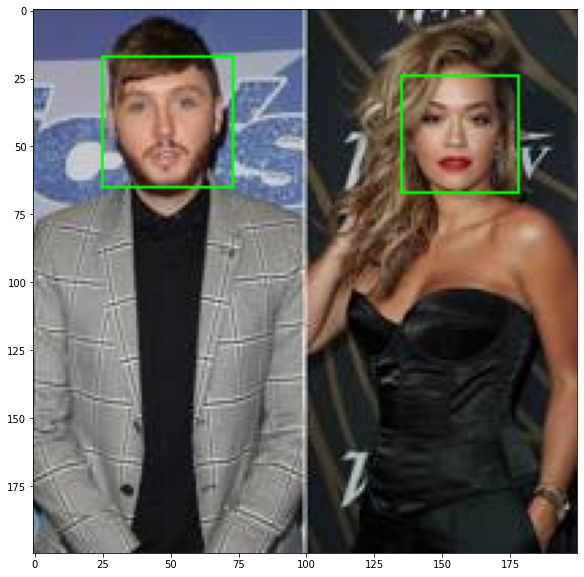

In [11]:
idx =3
plt.figure(1, figsize=(10, 10))
img = cv2.imread(multi_faces_dir[idx])

# Detect faces
faces = face_cascade.detectMultiScale(
    img,
    #scale factor is tuned starting from 1.05 to detect just the interesting faces
    scaleFactor=1.2,
    minNeighbors=5,
    minSize=(30, 30),
)

for (x, y, w, h) in faces: 
  cv2.rectangle(img, (x, y), (x+w, y+h), (0, 255, 0), 1)

img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(img)


(43, 43, 3)
(48, 48, 3)


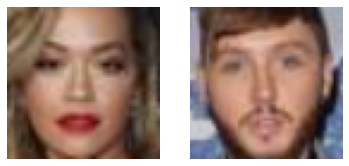

In [12]:
extract_faces = extract_faces(multi_faces_dir[idx],faces)
n= 0
i = 0

face_e = {'img_name': '', 'pixels': 0}
people_face = []


for img in extract_faces: 
  n+=1
  img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
  print(np.shape(img))
  image = cv2.resize(img,(64,64))
  image = np.array(image)
  pixel = image.ravel()
  pixel = pixel.tolist()
  pixel = str(pixel)[1:-1] 
  face_e = {'img_name': 'img'+str(i),
            'pixels': pixel }
  people_face.append(face_e)

  #print(img)
  plt.subplot(1, len(extract_faces), n)
  plt.axis('off')
  plt.imshow(image)
  i+=1

plt.show() 

In [13]:
df_faces = pd.DataFrame(people_face)
df_faces.head()

,img_name,pixels
0,img0,"151, 132, 102, 141, 121, 91, 134, 113, 82, 143..."
1,img1,"88, 88, 122, 97, 93, 125, 99, 92, 120, 93, 84,..."


**Part2**

In [14]:
utkFaces = pd.read_csv('/content/drive/MyDrive/Biometric-Project/UTKFaces2.csv')
utkFaces.head()

,age,gender,ethnicity,img_name,pixels
0,85,1,0,20170110182945927.jpg.chip.jpg,"207, 180, 150, 196, 169, 139, 202, 173, 143, 2..."
1,8,0,2,20170117192413109.jpg.chip.jpg,"24, 24, 26, 18, 22, 23, 17, 21, 22, 19, 19, 21..."
2,76,0,0,20170111221823004.jpg.chip.jpg,"244, 248, 249, 244, 248, 249, 244, 248, 251, 2..."
3,85,0,0,20170111210319130.jpg.chip.jpg,"167, 149, 129, 171, 163, 144, 211, 212, 196, 2..."
4,80,0,0,20170117173628559.jpg.chip.jpg,"186, 168, 146, 183, 167, 142, 181, 169, 143, 1..."


**Datataset Information extrapolation (from dataframe)**

In [15]:
#functions takes a series and returns the image and it's labels
def get_image(row):
  age = row['age']
  ethnicity = row['ethnicity']
  gender = row['gender']
  image = np.array(row['pixels'].split(','), 'float32')
  image = image.reshape(64, 64, 3) / 255.0

  return image, age, ethnicity, gender

**Labels Mapping** (Mapping of Age ranges)

In [16]:
ethnicity_mapping = {0:"White", 1:"Black", 2:"Asian", 3:"Indian", 4:"Hispanic"}
gender_mapping = {0:"Male", 1:"Female"}
age_mapping = {0: "6-22", 1: "23-39", 2: "40-59", 3: "60+"}

**Show Images function**

In [ ]:
def show_images():
  plt.figure(figsize=(30, 30))
  for i in range(16):
  #select random image
    idx = random.randint(0, len(utkFaces))
    image, age, ethnicity, gender = get_image(utkFaces.iloc[idx])
    plt.subplot(4, 4, i+1)
    plt.imshow(image)
    plt.title(' Age: {}\n Ethnicity: {}\n gender: {}'.format(age, ethnicity_mapping[ethnicity], gender_mapping[gender]))
  plt.show()

**Displying Images**

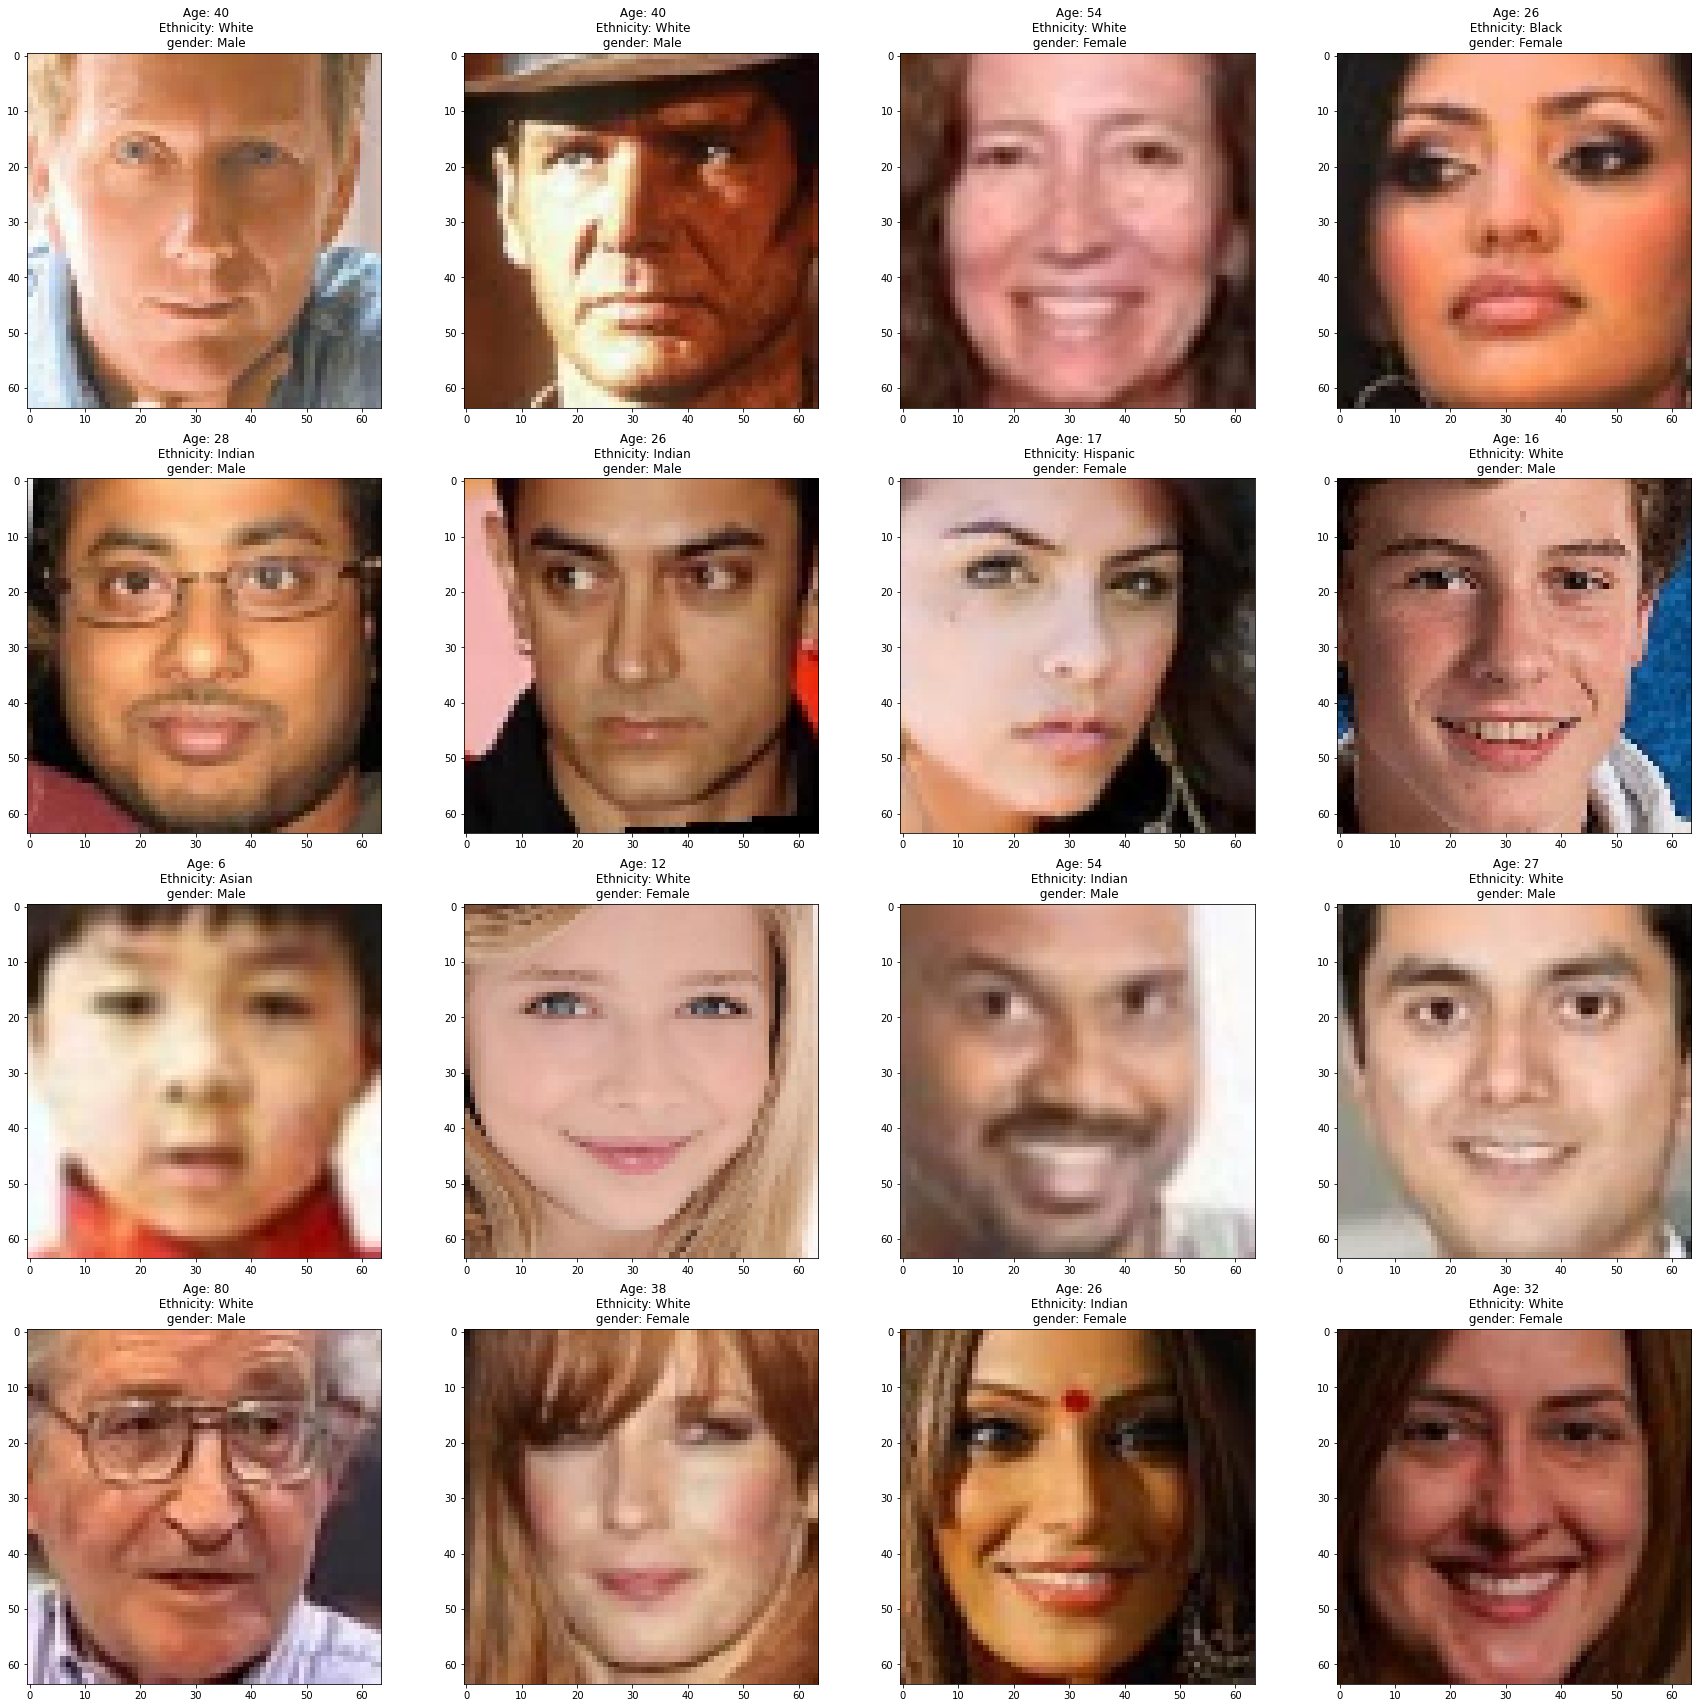

In [ ]:
show_images()

**Outlier Elimination, study of the distributions of samples and classes of age range definition**

In [17]:
utk_images = []
ages_list = []
genders_list = []
ethnicities_list = []
#just for final visualization 
age_true_list = []

for idx in range((len(utkFaces))): 
  image, age, ethnicity, gender = get_image(utkFaces.iloc[idx])
  if int(age)> 5 and int(age)<90:
    utk_images.append(image)
    age_true_list.append(age)
    if int(age) >5 and int(age) <= 22:
      age = 0
      ages_list.append(age)
    if int(age) >=23 and int(age) <= 39:
      age = 1
      ages_list.append(age)
    if int(age) >=40 and int(age) <= 59:
      age = 2
      ages_list.append(age)
    if int(age) >=60 and int(age):
      age = 3
      ages_list.append(age)
    
    ethnicities_list.append(ethnicity)
    genders_list.append(gender)

**Age ranges distribution**

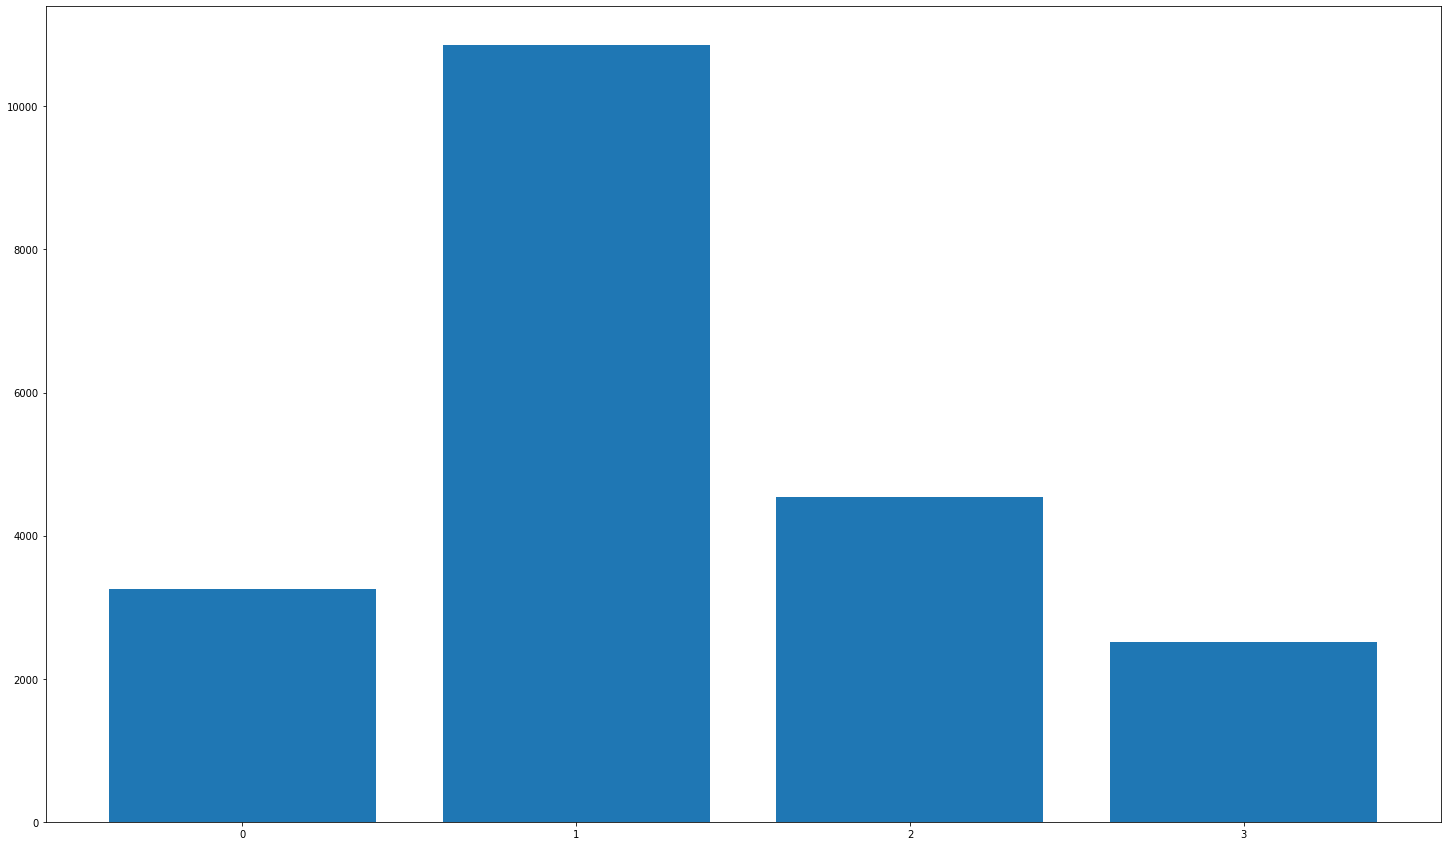

In [ ]:

plt.figure(1, figsize=(25, 15))
x_age_axis = list(set(ages_list))
x_age_axis = sorted(x_age_axis)
y_age_axis = [ages_list.count(i) for i in x_age_axis]
plt.xticks(np.arange(min(x_age_axis), max(x_age_axis)+1, 1.0))
plt.bar(x_age_axis,y_age_axis)
plt.show()

**Genders distribution** \\
*0:male, 1:female*

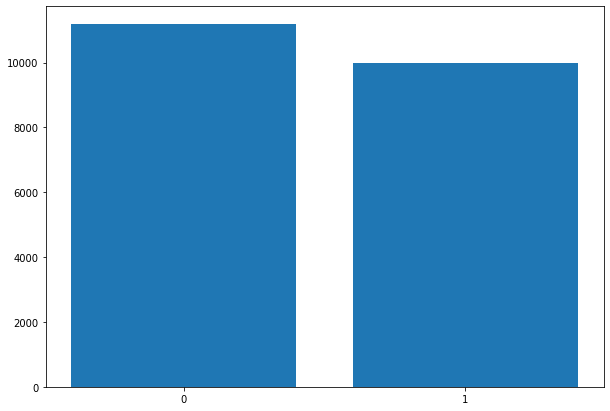

In [ ]:
plt.figure(1, figsize=(10, 7))
x_gen_axis = list(set(genders_list))
x_gen_axis = sorted(x_gen_axis, key=int)
y_gen_axis = [genders_list.count(i) for i in x_gen_axis]
plt.bar(x_gen_axis,y_gen_axis)
plt.xticks(np.arange(min(x_gen_axis), max(x_gen_axis)+1, 1.0))
plt.show()

**Ethnicities distribution** \\
*0:White, 1:Black, 2:Asian, 3:Indian, 4:Hispanic*

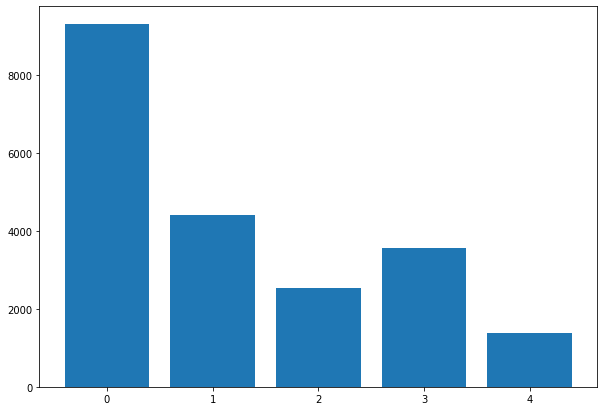

In [ ]:
plt.figure(1, figsize=(10, 7))
x_ethn_axis = list(set(ethnicities_list))
x_ethn_axis = sorted(x_ethn_axis, key=int)
y_ethn_axis = [ethnicities_list.count(i) for i in x_ethn_axis]
plt.bar(x_ethn_axis,y_ethn_axis)
plt.xticks(np.arange(min(x_ethn_axis), max(x_ethn_axis)+1, 1.0))
plt.show()

**Images array and Labels matrix creation**

In [18]:
matrix = np.zeros((len(utk_images),3),dtype='float32')
images = np.zeros((len(utk_images),64,64,3),dtype = 'float32')

for i in range(len(utk_images)):
  matrix[i,0] = int(ages_list[i])
  matrix[i,1] = int(genders_list[i])
  matrix[i,2] = int(ethnicities_list[i])
  images[i] = utk_images[i]

**Training and Test split**

In [19]:
from sklearn.model_selection import train_test_split
#training and test sets
X_train1, X_test, y_train1, y_test = train_test_split(images, matrix, test_size=0.2,shuffle=True)
print("Samples in Training:",X_train1.shape[0])
print("Samples in Validation:",X_test.shape[0])

Samples in Training: 16938
Samples in Validation: 4235


**Data augmentation** \\

*shifting*

In [20]:
def translate(img, shift, direction, roll=True):
    assert direction in ['right', 'left', 'down', 'up'], 'Directions should be top|up|left|right'
    img = img.copy()
    if direction == 'right':
        right_slice = img[:, -shift:].copy()
        img[:, shift:] = img[:, :-shift]
        if roll:
            img[:,:shift] = np.fliplr(right_slice)
    if direction == 'left':
        left_slice = img[:, :shift].copy()
        img[:, :-shift] = img[:, shift:]
        if roll:
            img[:, -shift:] = left_slice
    if direction == 'down':
        down_slice = img[-shift:, :].copy()
        img[shift:, :] = img[:-shift,:]
        if roll:
            img[:shift, :] = down_slice
    if direction == 'up':
        upper_slice = img[:shift, :].copy()
        img[:-shift, :] = img[shift:, :]
        if roll:
            img[-shift:,:] = upper_slice
    return img

*flip*

In [21]:
def flip(img): 
  img = cv2.flip(img, 1)
  return img 

*distorsion*

In [22]:
def distort(img, orientation='horizontal', func=np.sin, x_scale=0.05, y_scale=5):
  assert orientation[:3] in ['hor', 'ver'], "dist_orient should be 'horizontal'|'vertical'"
  assert func in [np.sin, np.cos], "supported functions are np.sin and np.cos"
  assert 0.00 <= x_scale <= 0.1, "x_scale should be in [0.0, 0.1]"
  assert 0 <= y_scale <= min(img.shape[0], img.shape[1]), "y_scale should be less then image size"
  img_dist = img.copy()
    
  def shift(x):
    return int(y_scale * func(np.pi * x * x_scale))
    
    for c in range(3):
      for i in range(img.shape[orientation.startswith('ver')]):
        if orientation.startswith('ver'):
          img_dist[:, i, c] = np.roll(img[:, i, c], shift(i))
        else:
          img_dist[i, :, c] = np.roll(img[i, :, c], shift(i))
            
  return img_dist

*average of samples for each class*

In [23]:
#compute the new avg in the training set 
ages = []
eth = []
for i in range(0,len(X_train1)): 
  ages.append(y_train1[i,0])
  eth.append(y_train1[i,2])

#ages average in train set
a_samples = list(set(ages))
na_samples = [ages.count(i) for i in a_samples]
age_train_avg = sum(na_samples)/len(a_samples)
print(age_train_avg)

#ethnicities average in train set
e_samples = list(set(eth))
ne_samples = [eth.count(i) for i in e_samples]

eth_train_avg = sum(ne_samples)/len(e_samples)
print(eth_train_avg)

4234.5
3387.6


*take only classes under the respective avg to augment*

In [24]:
j = 0
samples_ages = []
samples_eth = []

#take ages under the ages avg 
for i in a_samples:
  if na_samples[j] < age_train_avg:
    samples_ages.append(i)
  j+=1

j=0
#take ethnicity classes under the ethnicity avg 
for i in e_samples:
  if ne_samples[j] < eth_train_avg:
    samples_eth.append(i)
  j+=1

minor_age_avg = samples_ages
minor_eth_avg = samples_eth

#classes under the average
print(minor_age_avg) #ages
print(minor_eth_avg) #ethnicities

[0.0, 2.0, 3.0]
[2.0, 3.0, 4.0]


*creation of an array of augumented images with the related labels*



In [25]:
count_tot_ages = 0
count_tot_eth = 0
moves = ['right', 'left', 'down', 'up']
pos = ['ver', 'hor']
count = 0
x_param = [0.01, 0.02, 0.03]
y_param = [1, 2] 

for i in range(0,len(y_train1)): 
  age = y_train1[i,0]
  eth = y_train1[i,2]
  if age in minor_age_avg: 
    count_tot_ages+=1
  if eth in minor_eth_avg: 
    count_tot_eth+=1
  
  if (age in minor_age_avg) and (eth in minor_eth_avg):
    count +=1
len_aug = count
images2 = np.zeros((len_aug,64,64,3),dtype = 'float32')
matrix2 = np.zeros((len_aug,3),dtype='float32')

j = 0
for i in range(0,len(y_train1)): 
  
  img = X_train1[i]

  age = y_train1[i,0]
  gender =  y_train1[i,1]
  eth = y_train1[i,2]

  n = random.uniform(0,1)

  if (age in minor_age_avg) and (eth in minor_eth_avg): 
    
    if n >= 0.8: 
      
      dist = random.choice(pos)
      x_p = random.choice(x_param)
      y_p = random.choice(y_param)
  
      img = distort(img, orientation=dist, x_scale=x_p, y_scale=y_p)

      matrix2[j,0] = age
      matrix2[j,1] = gender
      matrix2[j,2] = eth

      images2[j] = img


    if n < 0.8 and n >= 0.5:
      
      move = random.choice(moves)
      shf = random.randint(1,3)
      img = translate(img,shift=shf,direction=move)

      matrix2[j,0] = age
      matrix2[j,1] = gender
      matrix2[j,2] = eth

      images2[j] = img

    
    if n < 0.5: 
      
      img = flip(img)
      
      matrix2[j,0] = age
      matrix2[j,1] = gender
      matrix2[j,2] = eth

      images2[j] = img

    j+=1


*union of the old training set with the augumented set*

In [26]:
X_train2_len = X_train1.shape[0] + images2.shape[0]

X_train2 = np.zeros((X_train2_len,64,64,3),dtype = 'float32')
y_train2 = np.zeros((X_train2_len,3),dtype = 'float32')

for i in range(0,len(X_train1)): 
  X_train2[i] = X_train1[i]

  y_train2[i,0] = y_train1[i,0]
  y_train2[i,1] = y_train1[i,1]
  y_train2[i,2] = y_train1[i,2]

j = 0
for i in range(len(X_train1), len(X_train2)):
  X_train2[i] = images2[j]

  y_train2[i,0] = matrix2[j,0]
  y_train2[i,1] = matrix2[j,1]
  y_train2[i,2] = matrix2[j,2]

  j+= 1


**New Training set with augmented data and Validation set**

In [27]:
X_train, X_val, y_train, y_val = train_test_split(X_train2, y_train2, test_size=0.2, shuffle=True)
print("Samples in Training:",X_train.shape[0])
print("Samples in Validation:",X_val.shape[0])

Samples in Training: 15415
Samples in Validation: 3854


*cont of samples for each class (ethnicities and gender) to look if the dataset is more balanced after data augmentation*

In [28]:
class_white = 0
class_black = 0
class_asian = 0
class_indian = 0
class_hispanic = 0

for j in range(0,len(y_train)): 
  i = int(y_train[j,2])
  if i == 0: 
    class_white+=1
  if i == 1: 
    class_black+=1
  if i == 2: 
    class_asian+=1
  if i == 3: 
    class_indian+=1
  if i == 4: 
    class_hispanic+=1
print(class_white,class_black,class_asian,class_indian,class_hispanic)

class_male = 0
class_female = 0

for j in range(0,len(y_train)): 
  i = int(y_train[j,1])
  if i == 0: 
    class_male+=1
  if i == 1: 
    class_female+=1

print(class_male,class_female)
  
class_age0 = 0
class_age1 = 0
class_age2 = 0
class_age3 = 0

for j in range(0,len(y_train)): 
  i = int(y_train[j,0])
  if i == 0: 
    class_age0+=1
  if i == 1: 
    class_age1+=1
  if i == 2: 
    class_age2+=1
  if i == 3: 
    class_age3+=1

print(class_age0,class_age1,class_age2,class_age3)


5967 2807 2183 3225 1233
8324 7091
2823 6933 3684 1975


**Model Base**

In [29]:
batch_size = 128
lr = 0.001
input_layer = Input(shape = (64, 64, 3))

#CNN used as BASE for feature extraction

conv1 = Conv2D(32, (3,3), activation='relu', padding='same', name='base_conv1')(input_layer)
batch1 = BatchNormalization(name='batch1')(conv1)

conv2 = Conv2D(32, (3,3), activation='relu', padding='same',name='base_conv2')(batch1)
batch2 = BatchNormalization(name='batch2')(conv2)
pool2 = MaxPooling2D(pool_size=(2, 2), name='base_pool2')(batch2)
drop2 = Dropout(0.25, name= 'base_drop2')(pool2)

conv3 = Conv2D(64, (3,3), activation='relu', padding='same', name='base_conv3')(drop2)
batch3 = BatchNormalization(name = 'batch3')(conv3)
pool3 = MaxPooling2D(pool_size=(2, 2), name='base_pool3')(batch3)
drop3 = Dropout(0.25, name= 'base_drop3')(pool3)

flat = Flatten(name= 'base_flatten')(drop3)

**Age Model** (4 classes for age-ranges --> Softmax activation function)

In [30]:
dropout_age = Dropout(0.5)
model_a = Dense(64,activation='relu', name = 'age_dense1')(flat)
model_a = BatchNormalization(name = 'age_batch1')(model_a)
model_a = dropout_age(model_a)


model_a = Dense(64,activation='relu', name = 'age_dense2')(model_a)
model_a = BatchNormalization(name = 'age_batch2')(model_a)
model_a = dropout_age(model_a)

#change of the last layer for the age classification 
model_a = Dense(4,activation='softmax', name='age')(model_a)

**Gender Model**

In [31]:
dropout_gender = Dropout(0.5)
model_g = Dense(64,activation='relu', name = 'gender_dense1')(flat)
model_g = BatchNormalization(name='gender_batch1')(model_g)
model_g = dropout_gender(model_g)

model_g = Dense(64,activation='relu', name = 'gender_dense2')(model_g)
model_g = BatchNormalization(name='gender_batch2')(model_g)
model_g = dropout_gender(model_g)

model_g= Dense(1, activation='sigmoid', name='gender')(model_g)

**Ethnicity model**

In [32]:
dropout_eth = Dropout(0.5)
model_e = Dense(64,activation='relu', name = 'eth_dense1')(flat)
model_e = BatchNormalization(name = 'eth_batch1')(model_e)
model_e = dropout_eth(model_e)

model_e = Dense(64,activation='relu', name = 'eth_dense2')(model_e)
model_e = BatchNormalization(name='eth_batch2')(model_e)
model_e = dropout_eth(model_e)

model_e = Dense(5, activation='softmax', name='ethnicity')(model_e)


**Final Model** (Since ages are considered as classes, sparse categorical crossentropy is used as loss)

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 64, 64, 3)]  0           []                               
                                                                                                  
 base_conv1 (Conv2D)            (None, 64, 64, 32)   896         ['input_1[0][0]']                
                                                                                                  
 batch1 (BatchNormalization)    (None, 64, 64, 32)   128         ['base_conv1[0][0]']             
                                                                                                  
 base_conv2 (Conv2D)            (None, 64, 64, 32)   9248        ['batch1[0][0]']                 
                                                                                              

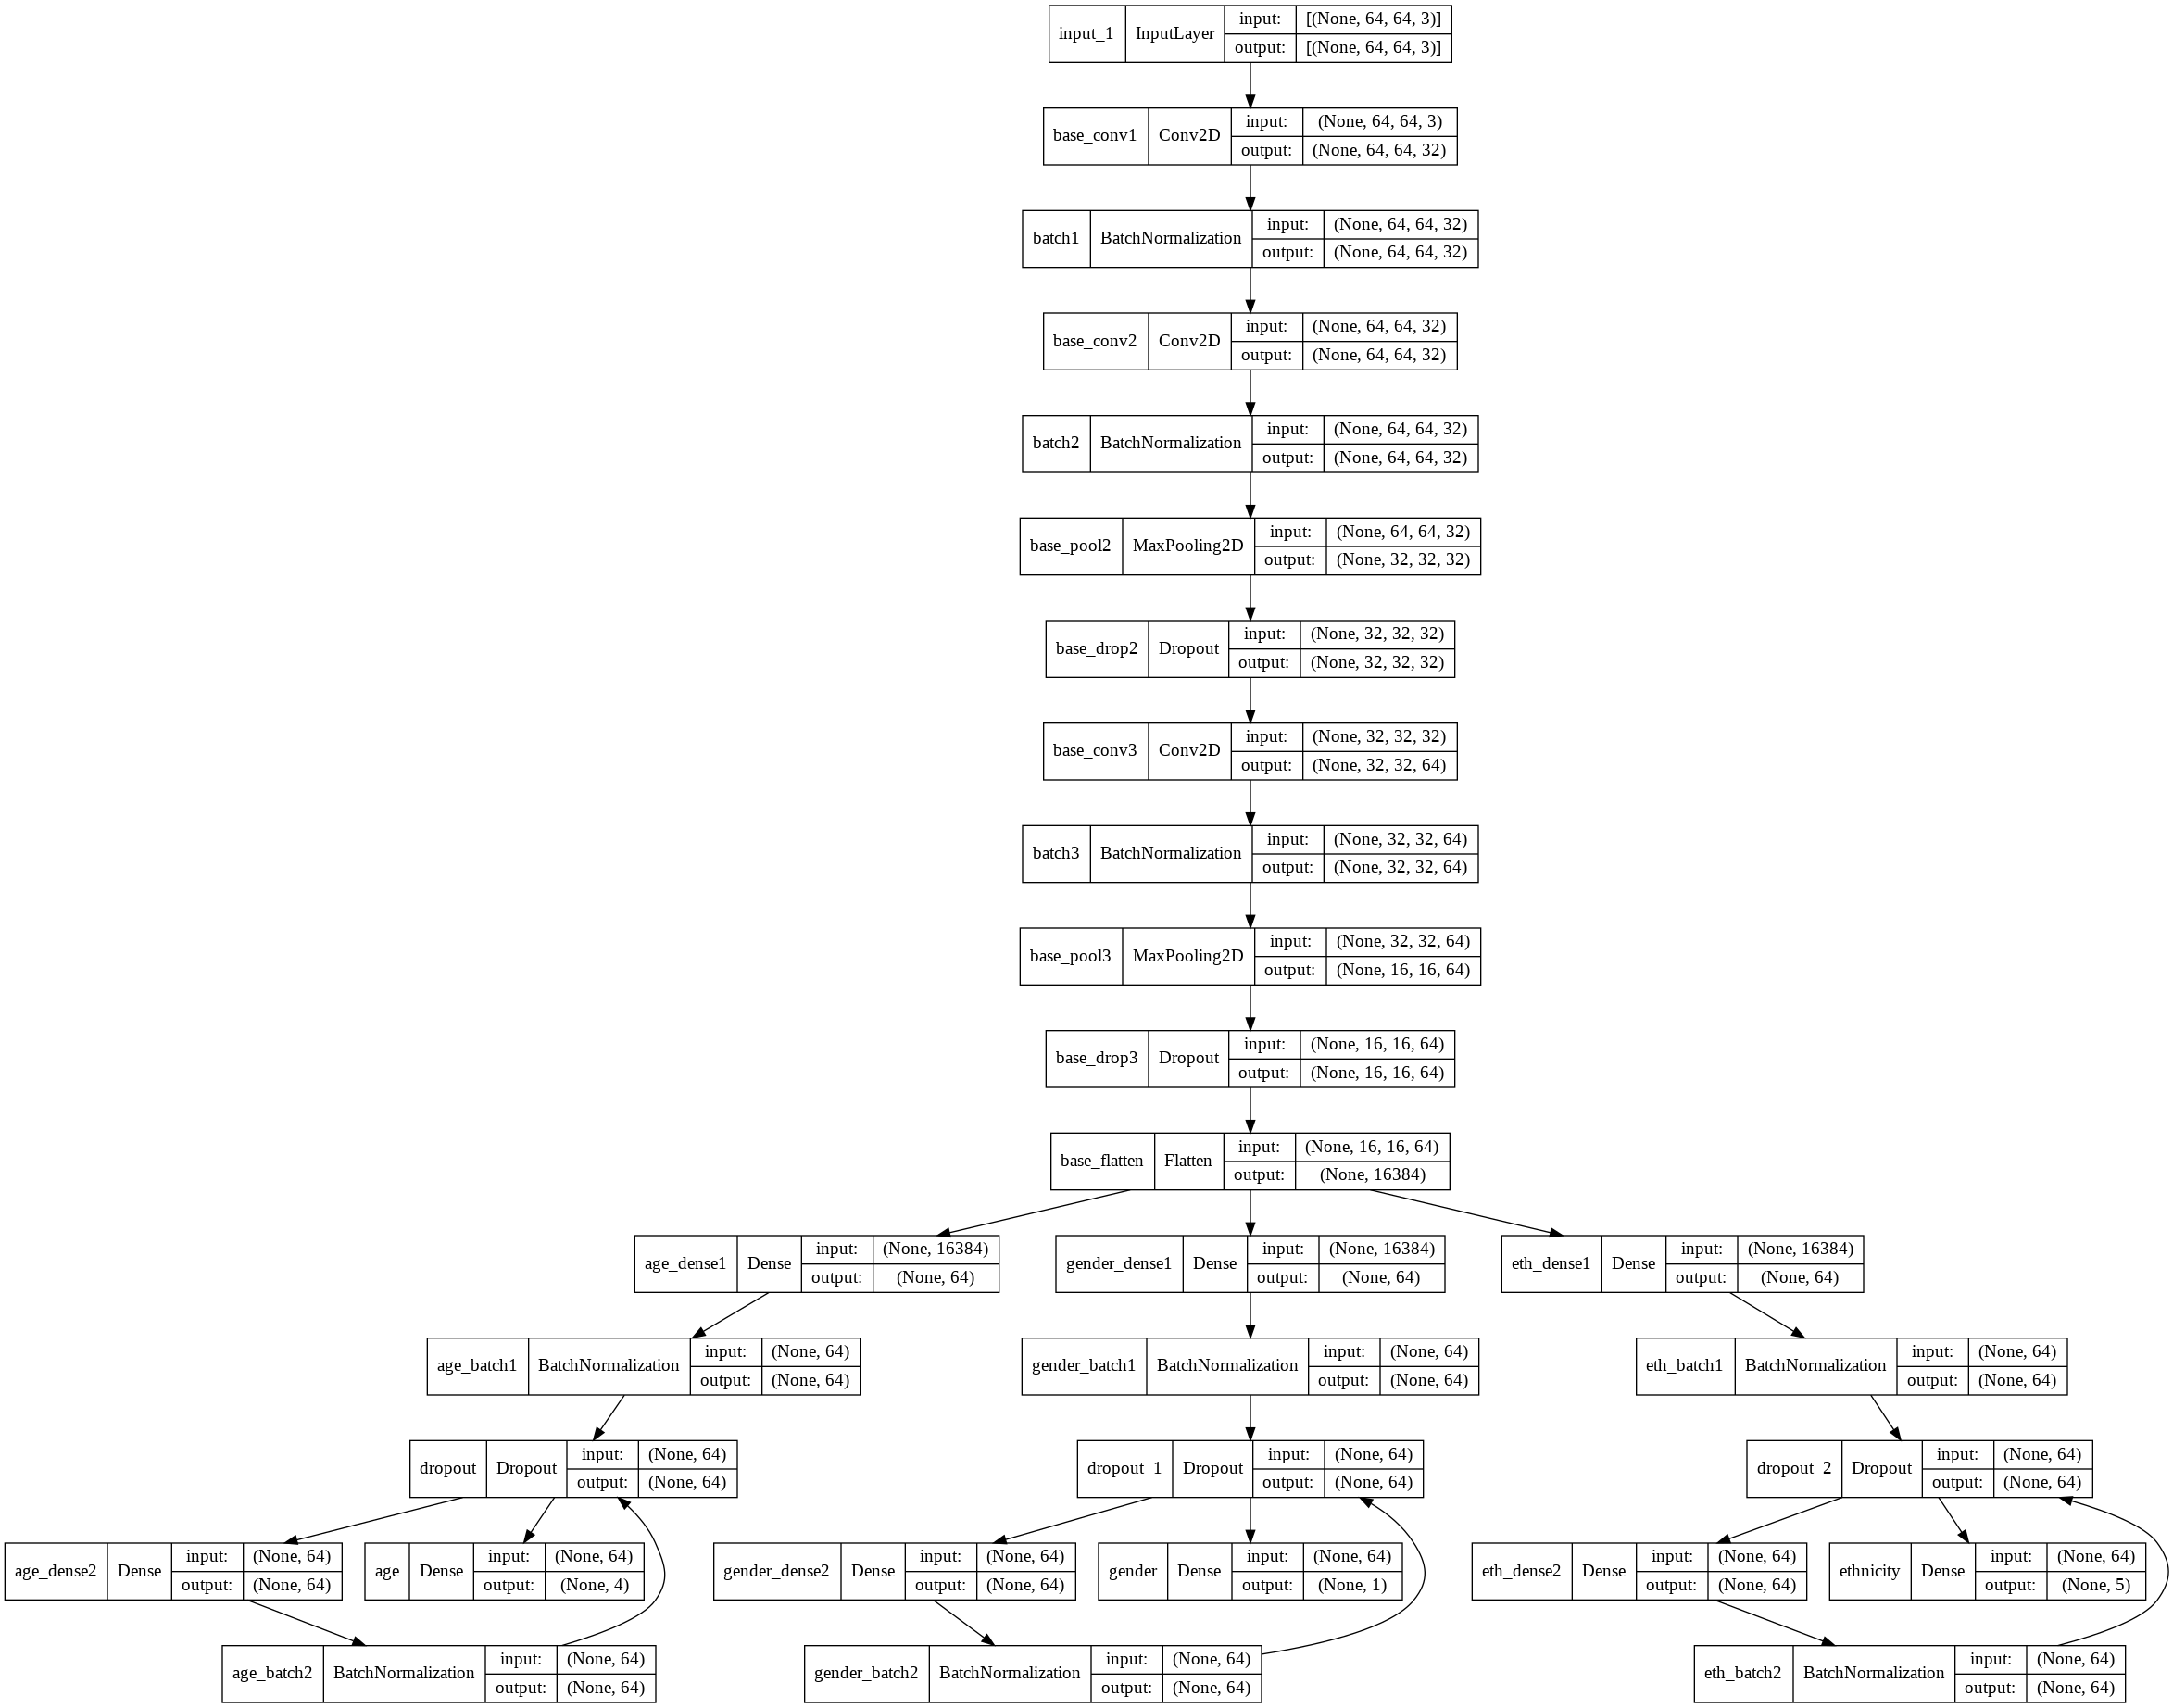

In [33]:
#Final model
model = Model(inputs=input_layer, outputs=[model_a,model_g, model_e])

adam = Adam(learning_rate=lr)
model.compile(
    loss = {
        'age' :'sparse_categorical_crossentropy',
        'gender': 'binary_crossentropy',
        'ethnicity': 'sparse_categorical_crossentropy'
    }, 
    
    optimizer=adam, 
    metrics={
        'age':'accuracy',
        'gender': 'accuracy',
        'ethnicity': 'accuracy'
    })
model.summary()

plot_model(model, to_file='stacked_model_plot.png', show_shapes=True, show_layer_names=True)

**Training**

In [ ]:
steps_per_epoch=len(X_train)//batch_size

#Stop training when a monitored metric has stopped improving
# loss is a parameter which  is a better estimator for EarlyStopping, since we can check if the model is overfitting 
# this is not guaranteed by the accurancy monitoring
EarlyStopping = EarlyStopping(#monitor='val_ethnicity_loss',
                              monitor = 'val_loss',
                              min_delta=0.01,
                              patience=4,
                              verbose=1,
                              mode='min',
                              baseline=None,
                              restore_best_weights=True)

#Reduce learning rate when a metric has stopped improving
#da sostituire
rlr = ReduceLROnPlateau(monitor="val_loss",
                            factor=0.01,
                            patience=3,
                            verbose=0,
                            mode="min",
                            min_delta=0.01)

model_save = ModelCheckpoint(filepath='/content/drive/MyDrive/Biometric-Project/models/trained_Model2.h5',
                             save_best_only = True,
                             save_weights_only = False,
                             monitor = 'val_loss', 
                             mode = 'min')

try:

    history = model.fit(X_train,[y_train[:,0],y_train[:,1],y_train[:,2]], 
                                  epochs=100, verbose=1, 
                                  validation_data=(X_val,[y_val[:,0],y_val[:,1], y_val[:,2]]),
                                  #shuffle = True,
                                  steps_per_epoch=steps_per_epoch, 
                                  callbacks=[EarlyStopping,rlr, model_save])

except KeyboardInterrupt:
    pass

Epoch 1/100
120/120 [==============================] - 41s 51ms/step - loss: 4.4738 - age_loss: 1.9236 - gender_loss: 0.6088 - ethnicity_loss: 1.9414 - age_accuracy: 0.3408 - gender_accuracy: 0.7186 - ethnicity_accuracy: 0.3548 - val_loss: 3.9810 - val_age_loss: 1.3119 - val_gender_loss: 0.8758 - val_ethnicity_loss: 1.7932 - val_age_accuracy: 0.4453 - val_gender_accuracy: 0.5444 - val_ethnicity_accuracy: 0.3239
Epoch 2/100
120/120 [==============================] - 5s 40ms/step - loss: 2.5964 - age_loss: 1.2060 - gender_loss: 0.3135 - ethnicity_loss: 1.0769 - age_accuracy: 0.5016 - gender_accuracy: 0.8758 - ethnicity_accuracy: 0.6166 - val_loss: 3.0581 - val_age_loss: 1.1918 - val_gender_loss: 0.5883 - val_ethnicity_loss: 1.2780 - val_age_accuracy: 0.4453 - val_gender_accuracy: 0.6204 - val_ethnicity_accuracy: 0.4499
Epoch 3/100
120/120 [==============================] - 5s 40ms/step - loss: 2.0870 - age_loss: 0.9854 - gender_loss: 0.2412 - ethnicity_loss: 0.8603 - age_accuracy: 0.5813

**Load Trained Model**

In [34]:
models_dir = '/content/drive/MyDrive/Biometric-Project/models/'

def loadmodel(problem):
    filename = os.path.join(models_dir,'%s.h5' %problem)
    try:
        model = load_model(filename)
        print("\nModel loaded successfully from file %s\n" %filename)
    except OSError:
        print("\nModel file %s not found!!!\n" %filename)
        model = None
    return model

model = loadmodel('trained_Model2')


Model loaded successfully from file /content/drive/MyDrive/Biometric-Project/models/trained_Model2.h5



**Plot of Losses trends and model performances on training set**

In [ ]:
def model_performance(history): 
  figure, axis = plt.subplots(1, 7, figsize=(50,5))
  axis = axis.ravel()
  
  for i,element in enumerate(['loss','age_loss', 'gender_loss', 'ethnicity_loss','age_accuracy','gender_accuracy', 'ethnicity_accuracy']):
    axis[i].plot(history.history[element])
    axis[i].plot(history.history['val_' + element])
    axis[i].set_title('Model {}'.format(element))
    axis[i].set_xlabel('epochs')
    axis[i].set_ylabel(element)
    axis[i].legend(['train', 'val'])


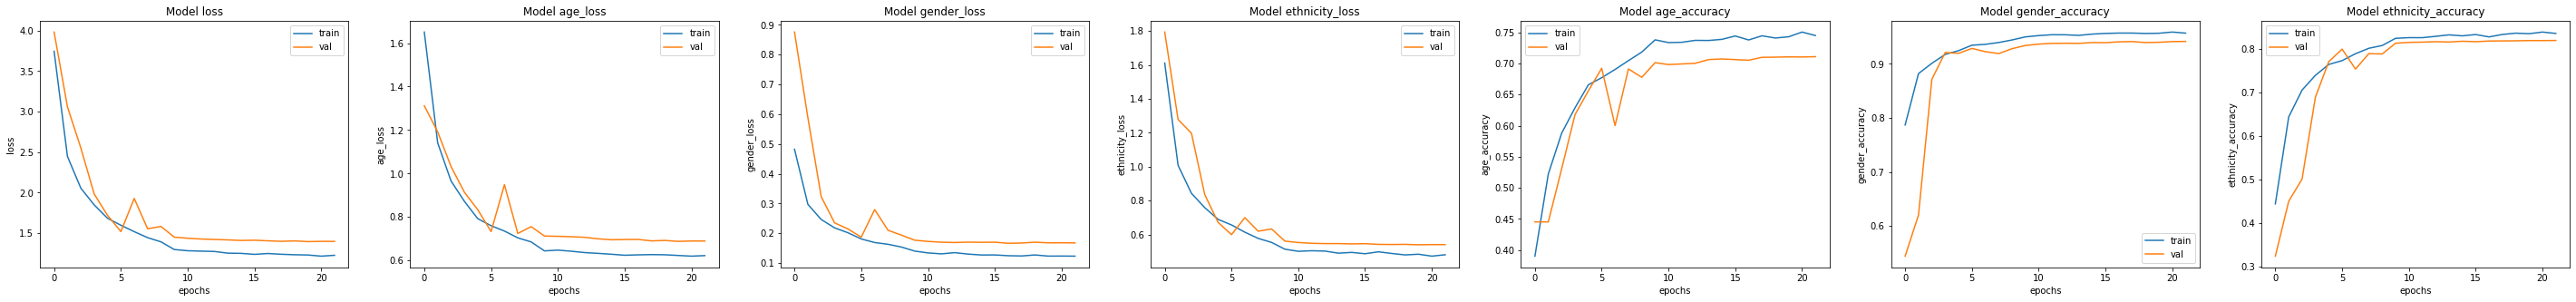

In [ ]:
model_performance(history)

In [39]:
loss, age_loss, gender_loss, ethnicity_loss, age_accuracy, gender_accuracy, ethnicity_accuracy = model.evaluate(X_test,[y_test[:,0],y_test[:,1],y_test[:,2]],verbose=1)
print('Test loss: {}'.format(loss))
print('Test age loss: {}'.format(age_loss))
print('Test gender loss: {}'.format(gender_loss))
print('Test ethnicity loss : {}'.format(ethnicity_loss))
print('Test age accuracy : {}'.format(age_accuracy))
print('Test gender accuracy : {}'.format(gender_accuracy))
print('Test ethnicity accuracy : {}'.format(ethnicity_accuracy))

133/133 [==============================] - 2s 15ms/step - loss: 1.1101 - age_loss: 0.6103 - gender_loss: 0.1079 - ethnicity_loss: 0.3919 - age_accuracy: 0.7594 - gender_accuracy: 0.9622 - ethnicity_accuracy: 0.8699
Test loss: 1.1101114749908447
Test age loss: 0.6102600693702698
Test gender loss: 0.10791663080453873
Test ethnicity loss : 0.39193490147590637
Test age accuracy : 0.7593860626220703
Test gender accuracy : 0.9622195959091187
Test ethnicity accuracy : 0.8698937296867371


**Age confusion Matrix**

133/133 [==============================] - 2s 10ms/step


Text(91.68, 0.5, 'True label')

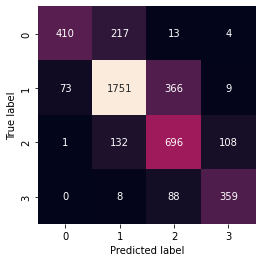

In [40]:
import seaborn as sns
from sklearn.metrics import confusion_matrix
#for sample in X_test:
values_cm = model.predict(X_test, verbose=1)
Ypred = np.argmax(values_cm[0], axis=1)
Ytest = y_test[:,0]
cm = confusion_matrix(Ytest, Ypred)

sns.heatmap(cm,square=True, annot=True, fmt='d', cbar=False,
            xticklabels=['0', '1','2','3'],
            yticklabels=['0', '1','2', '3'])
plt.xlabel('Predicted label')
plt.ylabel('True label')

**Gender Accuracy**

133/133 [==============================] - 1s 9ms/step


Text(91.68, 0.5, 'True label')

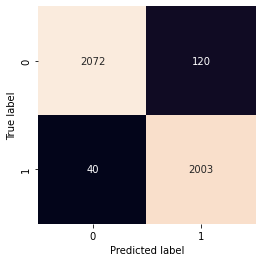

In [41]:
values_cm = model.predict(X_test, verbose=1)
Ypred = np.where(np.array(values_cm[1])>0.5,1,0)
Ytest = y_test[:,1]
cm = confusion_matrix(Ytest, Ypred)

sns.heatmap(cm,square=True, annot=True, fmt='d', cbar=False,
            xticklabels=['0', '1'],
            yticklabels=['0', '1'])
plt.xlabel('Predicted label')
plt.ylabel('True label')

**Ethnicity confusion Matrix**

133/133 [==============================] - 1s 9ms/step


Text(91.68, 0.5, 'True label')

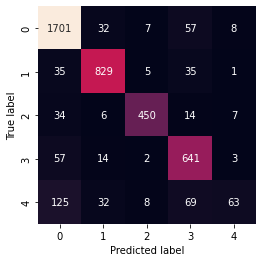

In [42]:
values_cm = model.predict(X_test, verbose=1)
Ypred = np.argmax(values_cm[2], axis=1)
Ytest = y_test[:,2]
cm = confusion_matrix(Ytest, Ypred)

sns.heatmap(cm,square=True, annot=True, fmt='d', cbar=False,
            xticklabels=['0', '1','2','3','4'],
            yticklabels=['0', '1','2', '3', '4'])
plt.xlabel('Predicted label')
plt.ylabel('True label')

**Evaluate the Model on dataset samples and external detected faces**

In [43]:
def display(img):
    plt.imshow(img)
    plt.show()
    

#age ranges
def get_age(probabilities):
  idx = np.argmax(probabilities[0])  
  return age_mapping[idx]


#gender estimation based on the output probability
def get_gender(prob):
    if prob < 0.5:return "Male"
    else: return "Female"

#take the most probable index of the predicted ethnicities array
def get_ethnicity(probabilities):
  idx = np.argmax(probabilities[0])
  return ethnicity_mapping[idx]

#prediction on given samples
def make_prediction(sample): 
  values = model.predict(np.array([sample], dtype='float32'))
  return values

def get_result(sample):
    old_stdout = sys.stdout # backup current stdout
    sys.stdout = open(os.devnull, "w")
    val = make_prediction(sample)
    sys.stdout = old_stdout 
    age_range = get_age(val[0])
    gender = get_gender(val[1])
    ethnicity = get_ethnicity(val[2])
    print("Predicted Gender:",gender,"\n","Predicted Age:", age_range,"\n","Predicted Ethnicity:",ethnicity)

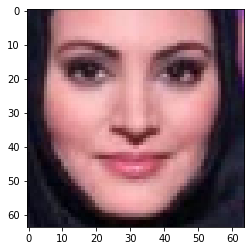

True Gender: Female , True Age: 30 , True Ethnicity:  Hispanic
Predicted Gender: Female 
 Predicted Age: 23-39 
 Predicted Ethnicity: White


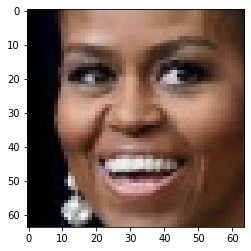

True Gender: Female , True Age: 50 , True Ethnicity:  Black
Predicted Gender: Female 
 Predicted Age: 23-39 
 Predicted Ethnicity: Black


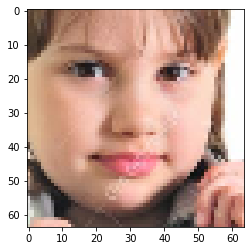

True Gender: Female , True Age: 8 , True Ethnicity:  White
Predicted Gender: Female 
 Predicted Age: 6-22 
 Predicted Ethnicity: White


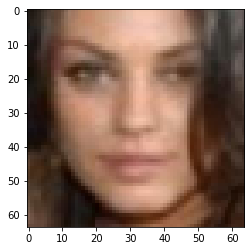

True Gender: Female , True Age: 23 , True Ethnicity:  White
Predicted Gender: Female 
 Predicted Age: 23-39 
 Predicted Ethnicity: White


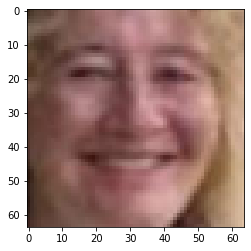

True Gender: Female , True Age: 45 , True Ethnicity:  White
Predicted Gender: Female 
 Predicted Age: 40-59 
 Predicted Ethnicity: White


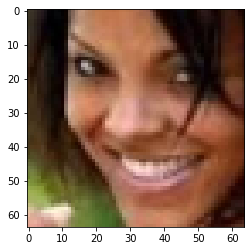

True Gender: Female , True Age: 26 , True Ethnicity:  Black
Predicted Gender: Female 
 Predicted Age: 23-39 
 Predicted Ethnicity: Black


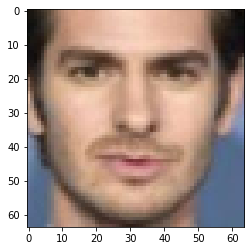

True Gender: Male , True Age: 30 , True Ethnicity:  White
Predicted Gender: Male 
 Predicted Age: 23-39 
 Predicted Ethnicity: White


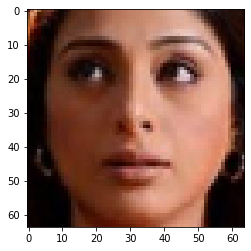

True Gender: Female , True Age: 27 , True Ethnicity:  Indian
Predicted Gender: Female 
 Predicted Age: 23-39 
 Predicted Ethnicity: Indian


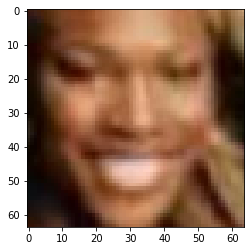

True Gender: Female , True Age: 40 , True Ethnicity:  Black
Predicted Gender: Female 
 Predicted Age: 23-39 
 Predicted Ethnicity: Black


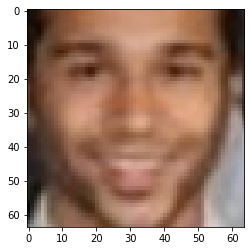

True Gender: Male , True Age: 25 , True Ethnicity:  Black
Predicted Gender: Male 
 Predicted Age: 23-39 
 Predicted Ethnicity: Black


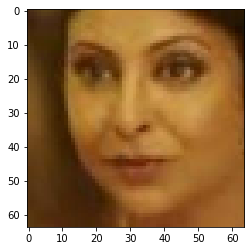

True Gender: Female , True Age: 50 , True Ethnicity:  Indian
Predicted Gender: Female 
 Predicted Age: 23-39 
 Predicted Ethnicity: Indian


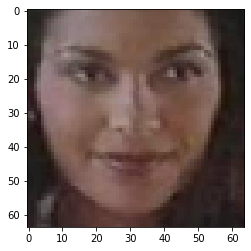

True Gender: Female , True Age: 40 , True Ethnicity:  White
Predicted Gender: Female 
 Predicted Age: 23-39 
 Predicted Ethnicity: White


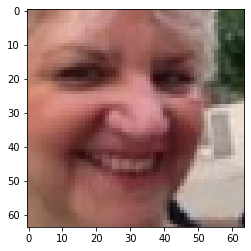

True Gender: Female , True Age: 68 , True Ethnicity:  White
Predicted Gender: Female 
 Predicted Age: 40-59 
 Predicted Ethnicity: White


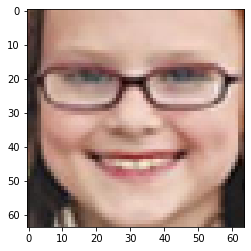

True Gender: Female , True Age: 12 , True Ethnicity:  White
Predicted Gender: Female 
 Predicted Age: 6-22 
 Predicted Ethnicity: White


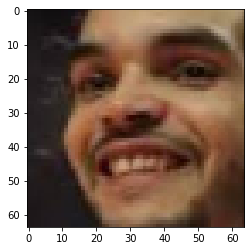

True Gender: Male , True Age: 27 , True Ethnicity:  Hispanic
Predicted Gender: Male 
 Predicted Age: 23-39 
 Predicted Ethnicity: White


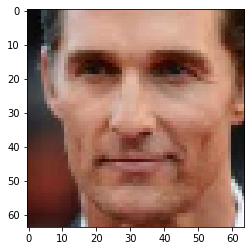

True Gender: Male , True Age: 45 , True Ethnicity:  White
Predicted Gender: Male 
 Predicted Age: 40-59 
 Predicted Ethnicity: White


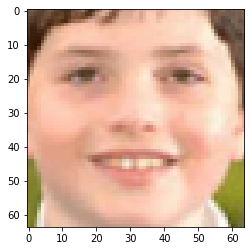

True Gender: Male , True Age: 9 , True Ethnicity:  White
Predicted Gender: Female 
 Predicted Age: 6-22 
 Predicted Ethnicity: White


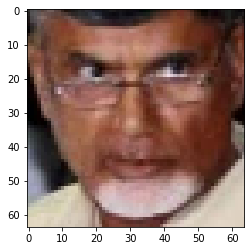

True Gender: Female , True Age: 55 , True Ethnicity:  Indian
Predicted Gender: Female 
 Predicted Age: 40-59 
 Predicted Ethnicity: Indian


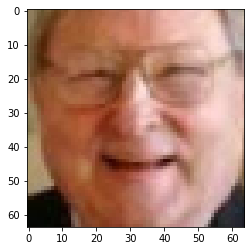

True Gender: Male , True Age: 61 , True Ethnicity:  White
Predicted Gender: Male 
 Predicted Age: 60+ 
 Predicted Ethnicity: White


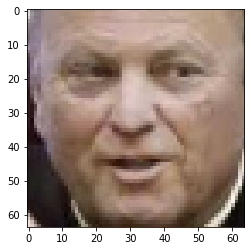

True Gender: Male , True Age: 65 , True Ethnicity:  White
Predicted Gender: Male 
 Predicted Age: 60+ 
 Predicted Ethnicity: White


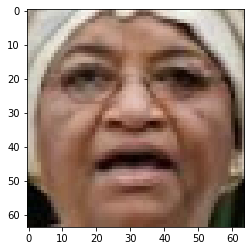

True Gender: Female , True Age: 55 , True Ethnicity:  Black
Predicted Gender: Female 
 Predicted Age: 40-59 
 Predicted Ethnicity: Black


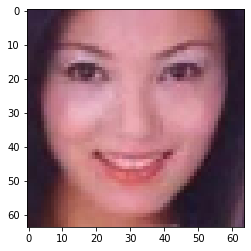

True Gender: Female , True Age: 27 , True Ethnicity:  Asian
Predicted Gender: Female 
 Predicted Age: 23-39 
 Predicted Ethnicity: Asian


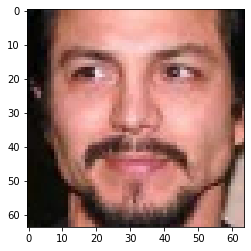

True Gender: Male , True Age: 32 , True Ethnicity:  Hispanic
Predicted Gender: Male 
 Predicted Age: 23-39 
 Predicted Ethnicity: White


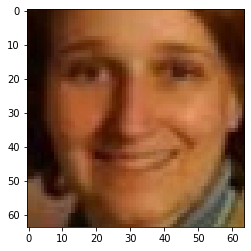

True Gender: Female , True Age: 54 , True Ethnicity:  White
Predicted Gender: Female 
 Predicted Age: 23-39 
 Predicted Ethnicity: White


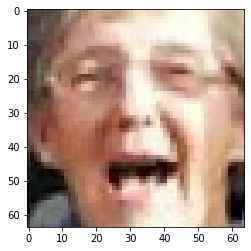

True Gender: Female , True Age: 85 , True Ethnicity:  White
Predicted Gender: Female 
 Predicted Age: 60+ 
 Predicted Ethnicity: White


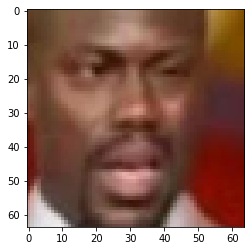

True Gender: Male , True Age: 29 , True Ethnicity:  Black
Predicted Gender: Male 
 Predicted Age: 23-39 
 Predicted Ethnicity: Black


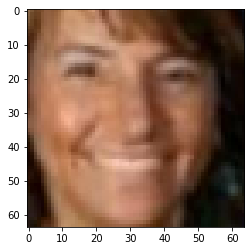

True Gender: Female , True Age: 39 , True Ethnicity:  White
Predicted Gender: Female 
 Predicted Age: 23-39 
 Predicted Ethnicity: White


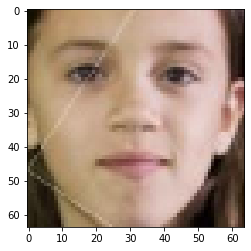

True Gender: Female , True Age: 8 , True Ethnicity:  White
Predicted Gender: Female 
 Predicted Age: 6-22 
 Predicted Ethnicity: White


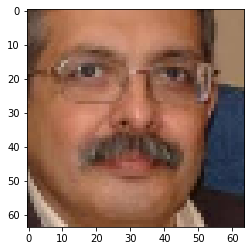

True Gender: Male , True Age: 52 , True Ethnicity:  Indian
Predicted Gender: Male 
 Predicted Age: 40-59 
 Predicted Ethnicity: Indian


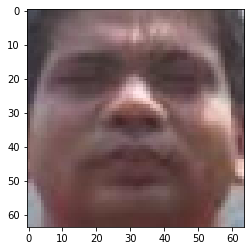

True Gender: Male , True Age: 26 , True Ethnicity:  Indian
Predicted Gender: Male 
 Predicted Age: 40-59 
 Predicted Ethnicity: Indian


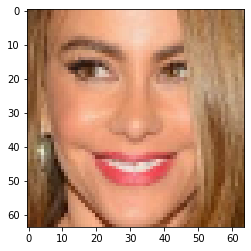

True Gender: Female , True Age: 43 , True Ethnicity:  White
Predicted Gender: Female 
 Predicted Age: 40-59 
 Predicted Ethnicity: White


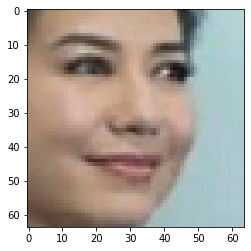

True Gender: Female , True Age: 40 , True Ethnicity:  Asian
Predicted Gender: Female 
 Predicted Age: 23-39 
 Predicted Ethnicity: Asian


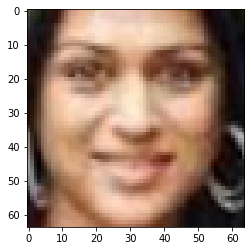

True Gender: Female , True Age: 26 , True Ethnicity:  Indian
Predicted Gender: Female 
 Predicted Age: 23-39 
 Predicted Ethnicity: Indian


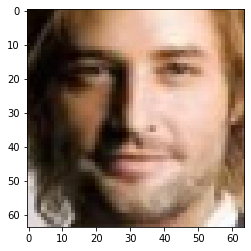

True Gender: Male , True Age: 32 , True Ethnicity:  White
Predicted Gender: Male 
 Predicted Age: 23-39 
 Predicted Ethnicity: White


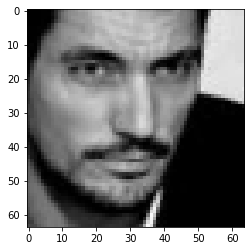

True Gender: Male , True Age: 45 , True Ethnicity:  White
Predicted Gender: Male 
 Predicted Age: 23-39 
 Predicted Ethnicity: White


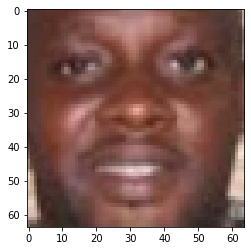

True Gender: Male , True Age: 32 , True Ethnicity:  Black
Predicted Gender: Male 
 Predicted Age: 40-59 
 Predicted Ethnicity: Black


In [44]:
for idx in range(36):
    idx = random.randint(0,len(utk_images))
    sample = utk_images[idx]
    display(sample)
    print("True Gender:",get_gender(genders_list[idx]),", True Age:",age_true_list[idx], ", True Ethnicity: ", ethnicity_mapping[ethnicities_list[idx]])
    res = get_result(sample)

**Test on external detected faces**

In [45]:
def get_face(row):
  img_name = row['img_name']
  print(img_name)
  face = np.array(row['pixels'].split(','), 'float32')
  face = face.reshape(64, 64,3) / 255.
  return img_name, face

img0


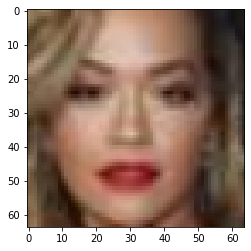

Predicted Gender: Female 
 Predicted Age: 23-39 
 Predicted Ethnicity: Asian
img1


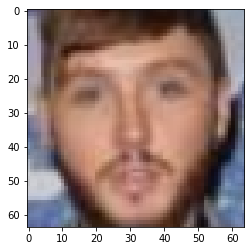

Predicted Gender: Male 
 Predicted Age: 23-39 
 Predicted Ethnicity: White


In [46]:
for idx in range((len(df_faces))): 
  img_name, face = get_face(df_faces.iloc[idx])
  display(face)
  res = get_result(face)